# MODEL SKINDECT versi Transfer Learning InceptionV3

## Import dari google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import library

In [ ]:
import urllib.request
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
from google.colab import files
from shutil import copyfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array

## Pembagian Data train dan validation

### Hapus Komentar Jika Data Belum Dibagi

In [ ]:

# # Tentukan direktori dataset
# dataset_dir = '/content/drive/MyDrive/DP'
# train_dir = os.path.join(dataset_dir, 'train')
# val_dir = os.path.join(dataset_dir, 'val')
# # test_dir = os.path.join(dataset_dir, 'test')

# # Buat folder untuk validasi dan uji jika belum ada
# os.makedirs(val_dir, exist_ok=True)
# # os.makedirs(test_dir, exist_ok=True)

# # Dapatkan daftar semua subfolder (kelas) dalam direktori pelatihan
# classes = os.listdir(train_dir)

# # Tentukan proporsi pembagian
# val_size = 0.2  # 20% untuk validasi
# # test_size = 0.1  # 10% untuk uji

# for class_name in classes:
#     class_path = os.path.join(train_dir, class_name)

#     # Pastikan itu adalah folder
#     if os.path.isdir(class_path):
#         # Buat folder untuk kelas di validasi dan uji
#         os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
#         # os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

#         # Dapatkan daftar semua gambar dalam kelas
#         all_images = os.listdir(class_path)

#         # Acak gambar
#         random.shuffle(all_images)

#         # Hitung jumlah gambar untuk validasi dan uji
#         num_val = int(len(all_images) * val_size)
#         # num_test = int(len(all_images) * test_size)

#         # Pindahkan gambar ke folder validasi
#         for image in all_images[:num_val]:
#             shutil.move(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

#         # Pindahkan gambar ke folder uji
#         # for image in all_images[num_val:num_val + num_test]:
#         #     shutil.move(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

# print("Pembagian dataset selesai")

Pembagian dataset selesai.


## Image Augmentation

In [ ]:
# Direktori dataset untuk data training
TRAINING_DIR = "/content/drive/MyDrive/Dataset SkinDect/train"

# Membuat data generator untuk augmentasi data training
# - rescale: Mengubah nilai piksel gambar ke rentang 0-1 dengan membagi setiap piksel dengan 255
# - rotation_range: Rotasi gambar secara acak hingga 40 derajat
# - width_shift_range & height_shift_range: Pergeseran gambar secara horizontal/vertikal sebesar 20% dari total dimensi
# - shear_range: Distorsi gambar melalui transformasi shear
# - zoom_range: Zoom in/out gambar secara acak hingga 20%
# - horizontal_flip: Membalik gambar secara horizontal secara acak
# - fill_mode: Metode untuk mengisi piksel kosong setelah transformasi (menggunakan metode 'nearest')
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Menggunakan generator untuk memuat data dari direktori training
# - batch_size: Jumlah data yang diproses setiap iterasi
# - class_mode: Jenis label yang digunakan ('categorical' karena data memiliki lebih dari dua kelas)
# - target_size: Ukuran gambar yang di-resize menjadi 150x150 piksel
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=100,
    class_mode='categorical',
    target_size=(150, 150)
)

# Direktori dataset untuk data validasi
VALIDATION_DIR = "/content/drive/MyDrive/Dataset SkinDect/val"

# Membuat data generator untuk data validasi
# - rescale: Sama seperti data training, nilai piksel diubah ke rentang 0-1
validation_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan generator untuk memuat data dari direktori validasi
# - batch_size, class_mode, target_size: Parameter sama seperti pada train_generator
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=100,
    class_mode='categorical',
    target_size=(150, 150)
)


Found 624 images belonging to 6 classes.
Found 156 images belonging to 6 classes.


## Mengimpor Transfer Learning InceptionV3

In [ ]:
# URL untuk mengunduh file bobot (weights) dari model InceptionV3 yang telah dilatih sebelumnya
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"

# Mengunduh file bobot dan menyimpannya dengan nama "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Membuat instance model InceptionV3
# - input_shape: Ukuran input gambar (150x150 piksel dengan 3 saluran warna/RGB)
# - include_top: False karena hanya akan menggunakan bagian feature extractor dari model tanpa fully connected layer di atas
# - weights: None karena bobot akan dimuat secara manual
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights=None
)

# Memuat bobot yang telah diunduh ke dalam model
pre_trained_model.load_weights(weights_file)

# Membekukan semua layer dari model agar tidak ikut dilatih (training)
for layer in pre_trained_model.layers:
    layer.trainable = False

# Menampilkan ringkasan arsitektur model (opsional, jika ingin digunakan)
# pre_trained_model.summary()

# Mendapatkan layer terakhir yang akan digunakan sebagai output dari model yang telah dilatih sebelumnya
last_layer = pre_trained_model.get_layer('mixed7')  # 'mixed7' adalah nama layer dalam arsitektur InceptionV3
print('last layer output shape: ', last_layer.output)  # Menampilkan bentuk keluaran dari layer terakhir
last_output = last_layer.output  # Menyimpan keluaran layer terakhir untuk digunakan dalam lapisan tambahan berikutnya


last layer output shape:  <KerasTensor shape=(None, 7, 7, 768), dtype=float32, sparse=False, name=keras_tensor_228>


## Membuat Model


In [ ]:
# Mengubah keluaran layer terakhir dari model yang telah dilatih sebelumnya menjadi satu dimensi
x = layers.Flatten()(last_output)

# Menambahkan lapisan fully connected dengan 16 unit tersembunyi dan fungsi aktivasi ReLU
x = layers.Dense(16, activation='relu')(x)

# Menambahkan lapisan fully connected dengan 64 unit tersembunyi dan fungsi aktivasi ReLU
x = layers.Dense(64, activation='relu')(x)

# Menambahkan lapisan fully connected dengan 128 unit tersembunyi dan fungsi aktivasi ReLU
x = layers.Dense(128, activation='relu')(x)

# Menambahkan lapisan Dropout untuk mencegah overfitting dengan dropout rate sebesar 30%
x = layers.Dropout(0.3)(x)

# Menambahkan lapisan output untuk klasifikasi dengan 6 kelas menggunakan fungsi aktivasi softmax
x = layers.Dense(6, activation='softmax')(x)

# Membuat model dengan masukan dari model pra-latih (pre-trained model) dan keluaran dari lapisan yang telah ditambahkan
model = Model(pre_trained_model.input, x)

# Menampilkan ringkasan arsitektur model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 9,587,574 (36.57 MB)

 Trainable params: 612,310 (2.34 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

### Compile Model dan Train Model


In [ ]:
# Menyusun model dengan menentukan optimizer, fungsi loss, dan metrik evaluasi
model.compile(optimizer='adam',  # Menggunakan optimizer Adam untuk mempercepat proses training
              # Anda juga dapat mengatur learning rate secara manual menggunakan: optimizer=Adam(learning_rate=0.001)
              loss='categorical_crossentropy',  # Menggunakan fungsi loss categorical_crossentropy untuk klasifikasi multi-kelas
              metrics=['accuracy'])  # Metrik evaluasi menggunakan akurasi

# Melatih model menggunakan data training dan memvalidasinya dengan data validasi
# Jumlah epoch dapat disesuaikan untuk meningkatkan performa model
history = model.fit(
            train_generator,  # Generator untuk data training
            validation_data=validation_generator,  # Generator untuk data validasi
            epochs=20,  # Jumlah epoch untuk proses training
            verbose=2)  # Menampilkan log pelatihan dengan tingkat detail sedang


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 - 218s - 31s/step - accuracy: 0.2019 - loss: 1.7746 - val_accuracy: 0.2821 - val_loss: 1.6827
Epoch 2/20
7/7 - 102s - 15s/step - accuracy: 0.3478 - loss: 1.6309 - val_accuracy: 0.4551 - val_loss: 1.4741
Epoch 3/20
7/7 - 51s - 7s/step - accuracy: 0.4247 - loss: 1.4340 - val_accuracy: 0.5000 - val_loss: 1.3392
Epoch 4/20
7/7 - 46s - 7s/step - accuracy: 0.5064 - loss: 1.2810 - val_accuracy: 0.5385 - val_loss: 1.2523
Epoch 5/20
7/7 - 47s - 7s/step - accuracy: 0.5529 - loss: 1.1559 - val_accuracy: 0.5962 - val_loss: 1.1787
Epoch 6/20
7/7 - 46s - 7s/step - accuracy: 0.5817 - loss: 1.0828 - val_accuracy: 0.5833 - val_loss: 1.1361
Epoch 7/20
7/7 - 85s - 12s/step - accuracy: 0.6122 - loss: 0.9980 - val_accuracy: 0.5705 - val_loss: 1.0313
Epoch 8/20
7/7 - 48s - 7s/step - accuracy: 0.6715 - loss: 0.9133 - val_accuracy: 0.6090 - val_loss: 1.0295
Epoch 9/20
7/7 - 81s - 12s/step - accuracy: 0.6683 - loss: 0.8857 - val_accuracy: 0.6154 - val_loss: 1.0004
Epoch 10/20
7/7 - 49s - 7s/step - accuracy

### Menampilkan Accuracy dan Val_acc

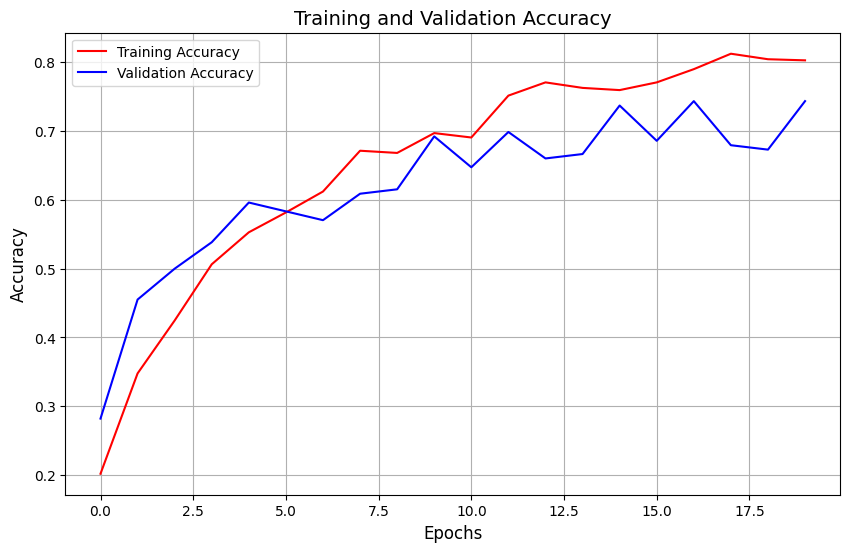

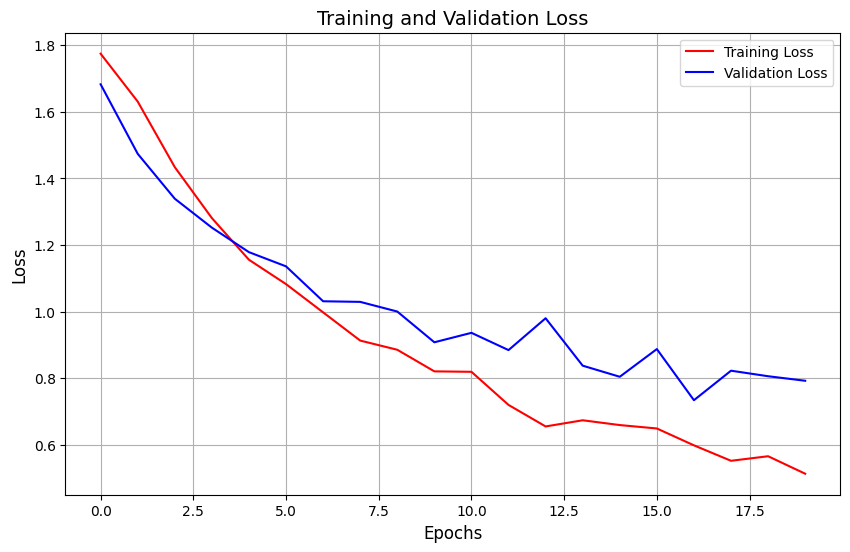

In [ ]:
# %matplotlib inline  # Digunakan untuk menampilkan plot langsung di notebook (aktifkan jika diperlukan)

import matplotlib.image as mpimg  # Modul untuk membaca dan memproses gambar
import matplotlib.pyplot as plt  # Modul untuk membuat plot dan visualisasi

# Mengambil daftar hasil akurasi dan loss pada data training dan validasi untuk setiap epoch
acc = history.history['accuracy']  # Akurasi pada data training
val_acc = history.history['val_accuracy']  # Akurasi pada data validasi
loss = history.history['loss']  # Loss pada data training
val_loss = history.history['val_loss']  # Loss pada data validasi

epochs = range(len(acc))  # Mendapatkan jumlah epoch berdasarkan panjang daftar akurasi

# Membuat plot akurasi training dan validasi per epoch
plt.figure(figsize=(10, 6))  # Membuat canvas dengan ukuran 10x6 inci
plt.plot(epochs, acc, 'r', label='Training Accuracy')  # Plot garis akurasi training dengan warna merah
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')  # Plot garis akurasi validasi dengan warna biru
plt.title('Training and Validation Accuracy', fontsize=14)  # Menambahkan judul plot
plt.xlabel('Epochs', fontsize=12)  # Label untuk sumbu-x
plt.ylabel('Accuracy', fontsize=12)  # Label untuk sumbu-y
plt.legend(loc='upper left')  # Menampilkan legenda di sudut kiri atas
plt.grid(True)  # Menampilkan grid pada plot
plt.show()  # Menampilkan plot akurasi

# Membuat plot loss training dan validasi per epoch
plt.figure(figsize=(10, 6))  # Membuat canvas baru dengan ukuran 10x6 inci
plt.plot(epochs, loss, 'r', label='Training Loss')  # Plot garis loss training dengan warna merah
plt.plot(epochs, val_loss, 'b', label='Validation Loss')  # Plot garis loss validasi dengan warna biru
plt.title('Training and Validation Loss', fontsize=14)  # Menambahkan judul plot
plt.xlabel('Epochs', fontsize=12)  # Label untuk sumbu-x
plt.ylabel('Loss', fontsize=12)  # Label untuk sumbu-y
plt.legend(loc='upper right')  # Menampilkan legenda di sudut kanan atas
plt.grid(True)  # Menampilkan grid pada plot
plt.show()  # Menampilkan plot loss


### Tes Upload Gambar

In [ ]:
# Mendefinisikan nama-nama kelas sesuai dengan dataset
class_names = ['biduran', 'cacar', 'eksim', 'kudis', 'kurap', 'panu']

# Mengunggah file gambar dari komputer ke Google Colab
uploaded = files.upload()

# Memproses setiap gambar yang diunggah
for fn in uploaded.keys():
    # Memuat gambar dari path yang ditentukan
    path = '/content/' + fn  # Path lokasi gambar di Colab
    img = load_img(path, target_size=(150, 150))  # Memuat gambar dengan ukuran yang disesuaikan (150x150 piksel)
    x = img_to_array(img)  # Mengonversi gambar menjadi array
    x /= 255  # Normalisasi nilai piksel menjadi rentang [0, 1]
    x = np.expand_dims(x, axis=0)  # Menambahkan dimensi batch untuk kompatibilitas model

    # Membuat tensor gambar untuk prediksi
    image_tensor = np.vstack([x])  # Menggabungkan array gambar menjadi tensor
    classes = model.predict(image_tensor)  # Melakukan prediksi pada gambar

    # Menampilkan hasil prediksi untuk setiap kelas
    print(f"Predictions for {fn}:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {classes[0][i]*100:.2f}%")  # Menampilkan probabilitas prediksi dalam persen

    # Menentukan kelas dengan skor prediksi tertinggi
    predicted_class = class_names[np.argmax(classes[0])]  # Mendapatkan indeks kelas dengan skor tertinggi
    print(f"\n{fn} is predicted to be {predicted_class}\n")  # Menampilkan hasil prediksi akhir


Saving panu.jpg to panu.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predictions for panu.jpg:
biduran: 0.71%
cacar: 5.73%
eksim: 1.61%
kudis: 1.36%
kurap: 6.50%
panu: 84.09%

panu.jpg is predicted to be panu



### Save Model

In [ ]:
# Menyimpan model yang telah dilatih ke dalam file dengan format .h5
model.save('/content/drive/MyDrive/MODEL/modelv2-6.h5')

### Convert ke TensorFlow Lite

In [ ]:
# Memuat model yang telah disimpan sebelumnya dari file .h5
model = tf.keras.models.load_model('/content/drive/MyDrive/MODEL/modelv2-6.h5')

# Mengonversi model ke format TensorFlow Lite (TFLite)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model dalam format TFLite ke file .tflite
with open('/content/drive/MyDrive/MODEL/modelv2-6.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpg1b_73c8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134468920869984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920879312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920881424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920877024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920884592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920919136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920875440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920920896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920923008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920922656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134468920920368